In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.metrics import accuracy_score

# import custom functions from src folder
module_path = str(Path.cwd() / "../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [16]:
color = ["#e41a1c", "#377eb8"]

In [17]:
#Data constants

shapes = [2, 6]#[2, 2]
scales = [5, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

trainfile = f"train_n_50000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"
test_data = pd.read_csv(f"data/{testfile}.csv")
grid_data = pd.read_csv(f"data/{gridfile}.csv")
train_data = pd.read_csv(f"data/{trainfile}.csv")

grid_rmax = grid_data["x1"].max()
print(grid_rmax)

n_train = [250, 500, 1000, 2000, 3000, 5000]
n_plots = len(n_train)

max_err_val = [0]*n_plots
for i in range(n_plots):
    if n_train[i] < 1000:
        max_err_val[i] = 0.4
    else:
        max_err_val[i] = 0.25


40.0


### Data

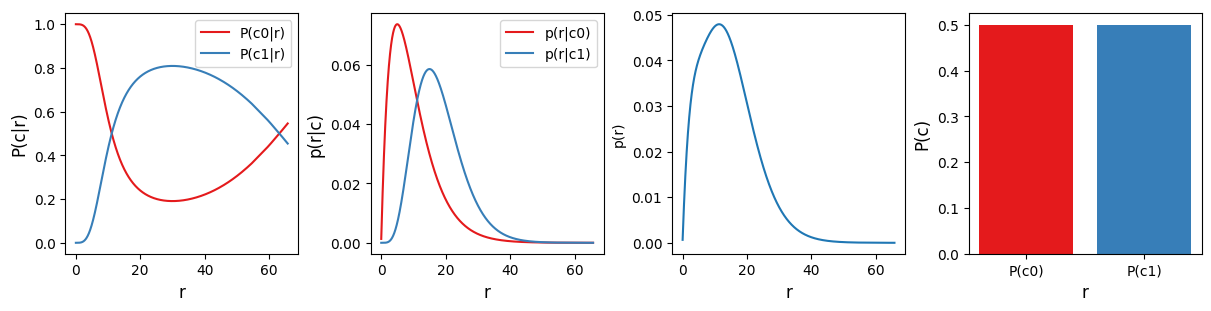

In [18]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (12, 3), layout="constrained")
for i in range(k):
    sn.lineplot(train_data, x="r", y=f"p_c{i}_given_r", label=f"P(c{i}|r)", ax=axs[0], c=color[i])
    axs[0].set_ylabel(r"P(c|r)", fontsize=12)
    axs[0].legend(loc="upper right")
    sn.lineplot(train_data, x="r", y=f"p_r_given_c{i}", label=f"p(r|c{i})", ax=axs[1], c=color[i])
    axs[1].set_ylabel(r"p(r|c)", fontsize=12)
    axs[1].legend(loc="upper right")
    axs[3].bar(x=[f"P(c{i})" for i in range(k)], height=p_c, color=color)
    axs[3].set_ylabel(f"P(c)", fontsize=12)

sn.lineplot(train_data, x="r", y="p_r", ax=axs[2])
axs[2].set_ylabel("p(r)")
for ax in axs:
    ax.set_xlabel("r", fontsize=12)
    #ax.set_xlim(0, 30)
fig.savefig(f"fig/data_{tag}.pdf", format="pdf", bbox_inches='tight', dpi=350)

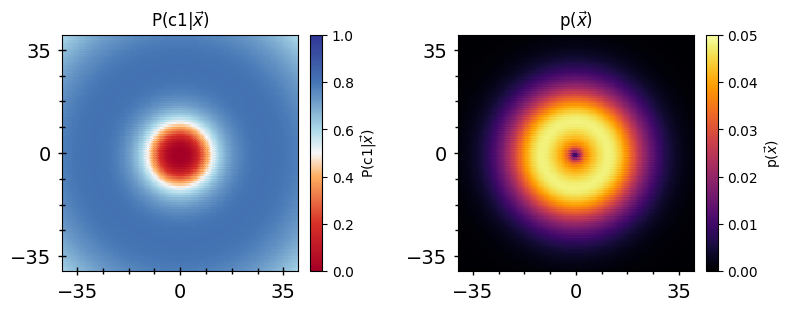

In [19]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (8,3), layout="constrained")
axs[0] = plot_results(grid_data, "p_c1_given_r", axs[0], r"P(c1|$\vec{x}$)", grid=True, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, label=r"P(c1|$\vec{x}$)", ax=axs[0])

axs[1] = plot_std(grid_data, "p_r", axs[1], r"p($\vec{x}$)", grid=True, max_val = 0.05, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=0.05, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, label=r"p($\vec{x}$)", ax=axs[1])

#fig.savefig(f"../fig/DNN_ensemble_ntrain_{n_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)

In [20]:
# Expected accuracy on any test set sampled from this distribution
exp_acc = np.sum(test_data[[f"p_c{i}_given_r" for i in range(k)]].max(axis=1))/len(test_data)
# But in our case, we will see the actual accuracy on this test set compared to expectation
test_data["Expected class"] = np.array(test_data[[f"p_c{i}_given_r" for i in range(k)]]).argmax(axis=-1)
max_acc = accuracy_score(test_data["class"], test_data["Expected class"], normalize=True)

print("Expected accuray: ", exp_acc, "Max optimal accuracy test set: ", max_acc)

Expected accuray:  0.7385207198110306 Max optimal accuracy test set:  0.7439


### Get results

In [21]:

model_names = ["NNE", 
               "CL",
               "EDL",
               "MCD", 
               #"BNN", 
               "GP", 
               "DPMM"]
pred_keys = ["Prediction_ensemble", 
             "Prediction_ensemble",
             "Prediction", 
             "Prediction_MC", 
             #"Prediction",
             "Prediction", 
             "Inferred_class"]
prob_keys = ["Confidence_avg", 
             "Confidence_avg", 
             "Est_prob_blue", 
             "Confidence_MC", 
             #"Est_prob_blue", 
             "Est_prob_blue_MC", 
             "Est_prob_blue"]
std_keys = ["Confidence_std", 
            "Confidence_std",
            "Uncertainty_scaled",
            "Std_MC", 
            #"Std_prob_blue", 
            "Std_prob_blue_MC", 
            "Std_samples_blue"]

bnn_lr_list = [0.028, 0.028, 0.05, 0.05, 0.05, 0.05]#[0.028, 0.028, 0.05, 0.05, 0.05, 0.05, 0.05]

n_models = len(model_names)

#pd.read_csv("DNN/predictions/train_n_50000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5/grid_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_predicted_SequentialNet_10ensembles_ndata-100.csv")

gridfiles = [
    [f"DNN/predictions/{trainfile}/ensemble/grid_{tag}_SequentialNet_10ensembles_best_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/CL/grid_{tag}_SequentialNet_CL_10ensembles_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/evidential/grid_{tag}_SequentialNet_evidential_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/MCD/grid_{tag}_SequentialNet_small_MCD_pd0.3_nMC_200_Vndata_best-{n}.csv" for n in n_train],
    #[f"BNN/predictions/{trainfile}/grid_{tag}_predicted_BNN_lr{lr}_sp0.1_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, n_train)],
    [f"gaussian_process/predictions/{trainfile}/grid_{tag}_predicted_latentGP_1_ls10_ndata-{n}.csv" for n in n_train],
    [f"inferno/predictions/{trainfile}/grid_{tag}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in n_train]
]

testfiles = [
    [f"DNN/predictions/{trainfile}/ensemble/{testfile}_SequentialNet_10ensembles_best_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/CL/{testfile}_SequentialNet_CL_10ensembles_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/evidential/{testfile}_SequentialNet_evidential_ndata-{n}.csv" for n in n_train],
    [f"DNN/predictions/{trainfile}/MCD/{testfile}_SequentialNet_small_MCD_pd0.3_nMC_200_Vndata_best-{n}.csv" for n in n_train],
    #[f"BNN/predictions/{trainfile}/{testfile}_predicted_BNN_lr{lr}_sp0.1_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, n_train)],
    [f"gaussian_process/predictions/{trainfile}/{testfile}_predicted_latentGP_1_ls10_ndata-{n}.csv" for n in n_train],
    [f"inferno/predictions/{trainfile}/{testfile}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in n_train]
]

grid_dfs = [[pd.read_csv(gridfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]
test_dfs = [[pd.read_csv(testfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]

#Corrections
for i in range(n_plots):
    #test_dfs[2][i]["class"] = test_dfs[0][i]["class"]
    grid_dfs[2][i]["Uncertainty_scaled"]=(grid_dfs[2][i]["Uncertainty"]/grid_dfs[2][i]["Uncertainty"].max())*grid_dfs[-1][i]["Std_samples_blue"].max()
    test_dfs[2][i]["Uncertainty_scaled"]=(test_dfs[2][i]["Uncertainty"]/grid_dfs[2][i]["Uncertainty"].max())*grid_dfs[-1][i]["Std_samples_blue"].max()

scores = [calculate_metrics(test_dfs[i], grid_dfs[i], n_train, grid_data, test_data, 
                           pred_keys[i], prob_keys[i], std_keys[i]) for i in range(n_models)]

scores_small = [calculate_metrics(test_dfs[i], grid_dfs[i], n_train, grid_data, test_data, 
                           pred_keys[i], prob_keys[i], std_keys[i], n_max=500) for i in range(n_models)]

In [22]:
for i in range (n_models):
    print(model_names[i])
    print(scores[i])

NNE
   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.717772  0.780473  0.063891  0.104734  0.076789  0.059468   
1     500  0.726673  0.787127  0.034968  0.074562  0.058292  0.044893   
2    1000  0.733073  0.794380  0.032071  0.074778  0.038394  0.025580   
3    2000  0.736774  0.803829  0.029601  0.071009  0.034459  0.022025   
4    3000  0.736274  0.801802  0.031118  0.058254  0.029840  0.015675   
5    5000  0.741174  0.805874  0.015710  0.035231  0.030227  0.015669   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.043585          0.021334  0.616930  0.089124  0.240602  0.114215  
1          0.028517          0.013673  0.562954  0.048323  0.186227  0.060592  
2          0.009542          0.010163  0.538254  0.032779  0.192310  0.041926  
3          0.005664          0.007773  0.526679  0.025851  0.376035  0.039285  
4          0.005311          0.007574  0.527808  0.031002  0.214900  0.039858  
5   

In [23]:
keys = ["N data", "ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test"]
best_score = pd.DataFrame(columns=keys)
best_score["N data"] = n_train

for i in range(n_plots):
    #Metrics that should be maximized
    for key in (["ACC", "ROCAUC"]):
        best_score.loc[i, key] = np.argmax([scores[j][key][i] for j in range(n_models)])
    for key in (["LogLoss", "Mean KL-div test", "ECE", "WD test"]):
        best_score.loc[i, key] = np.argmin([scores[j][key][i] for j in range(n_models)])
print(best_score)

   N data ACC ROCAUC LogLoss Mean KL-div test ECE WD test
0     250   3      3       3                3   3       3
1     500   3      3       3                3   3       3
2    1000   3      3       4                4   2       4
3    2000   4      3       4                4   4       4
4    3000   3      3       4                4   4       4
5    5000   4      3       4                4   4       4


In [24]:
keys = ["N data", "ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test"]
best_score_small = pd.DataFrame(columns=keys)
best_score_small["N data"] = n_train

for i in range(n_plots):
    #Metrics that should be maximized
    for key in (["ACC", "ROCAUC"]):
        best_score_small.loc[i, key] = np.argmax([scores_small[j][key][i] for j in range(n_models)])
    for key in (["LogLoss", "Mean KL-div test", "ECE", "WD test"]):
        best_score_small.loc[i, key] = np.argmin([scores_small[j][key][i] for j in range(n_models)])
print(best_score_small)

   N data ACC ROCAUC LogLoss Mean KL-div test ECE WD test
0     250   3      3       3                3   3       3
1     500   3      3       3                3   3       3
2    1000   4      4       4                3   2       2
3    2000   2      3       2                4   4       4
4    3000   4      5       5                4   4       4
5    5000   0      5       5                4   4       4


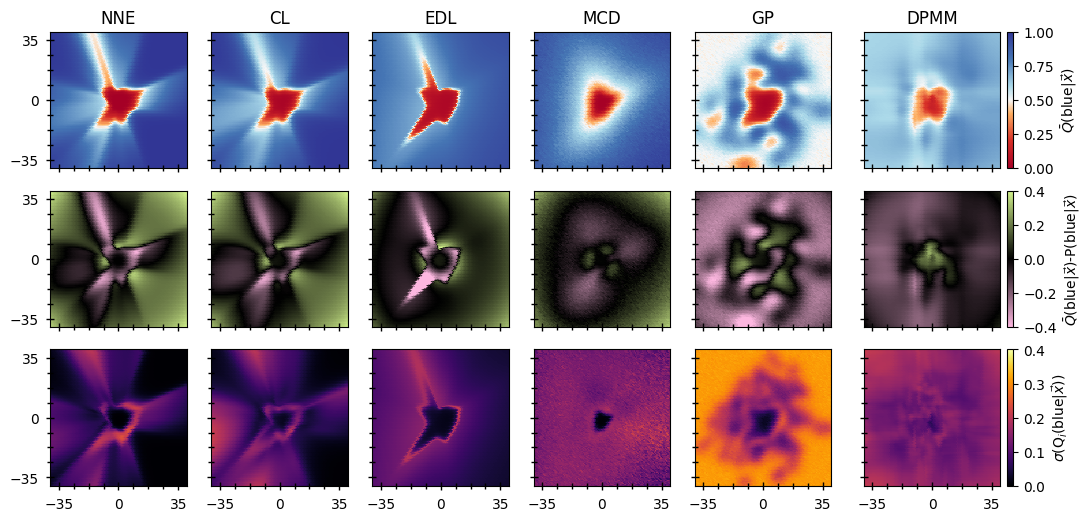

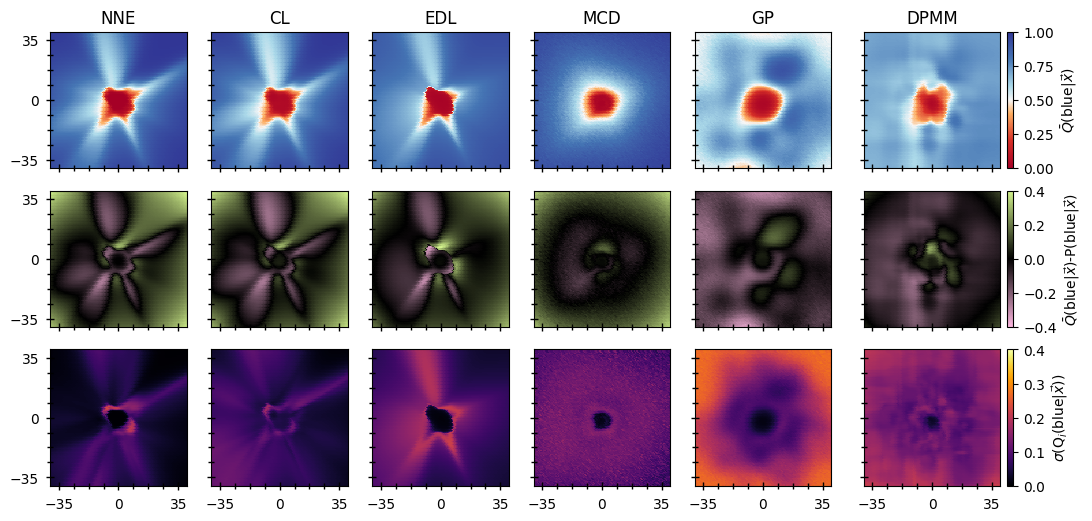

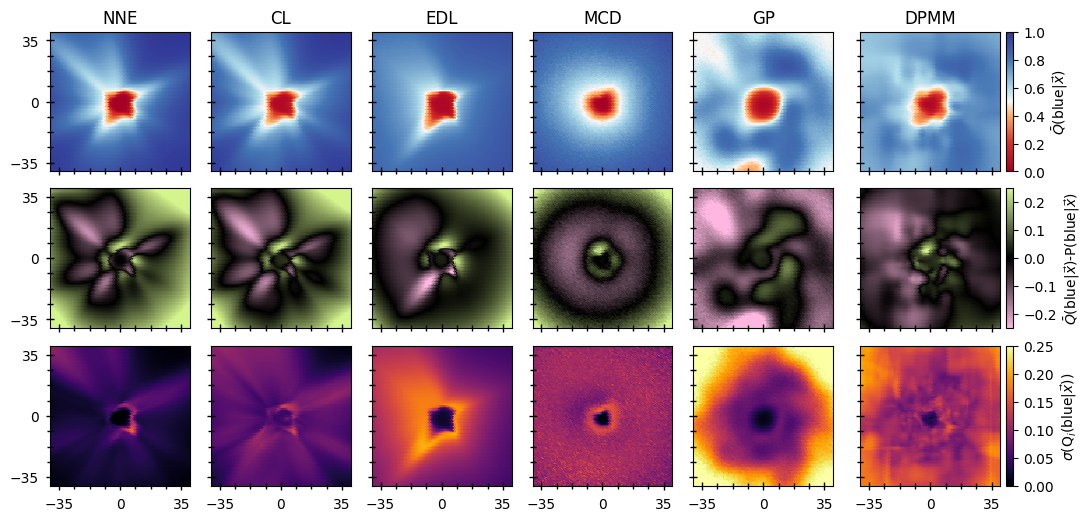

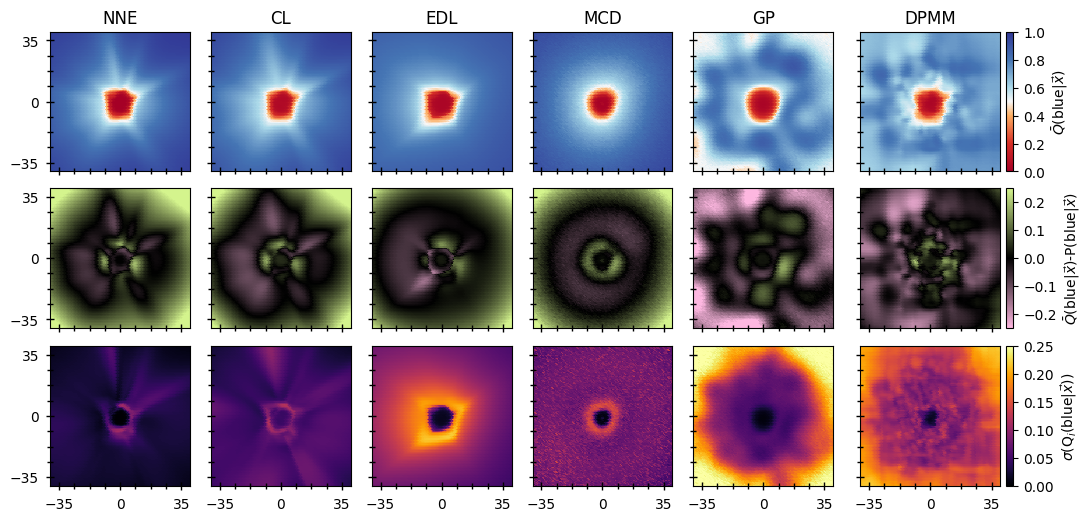

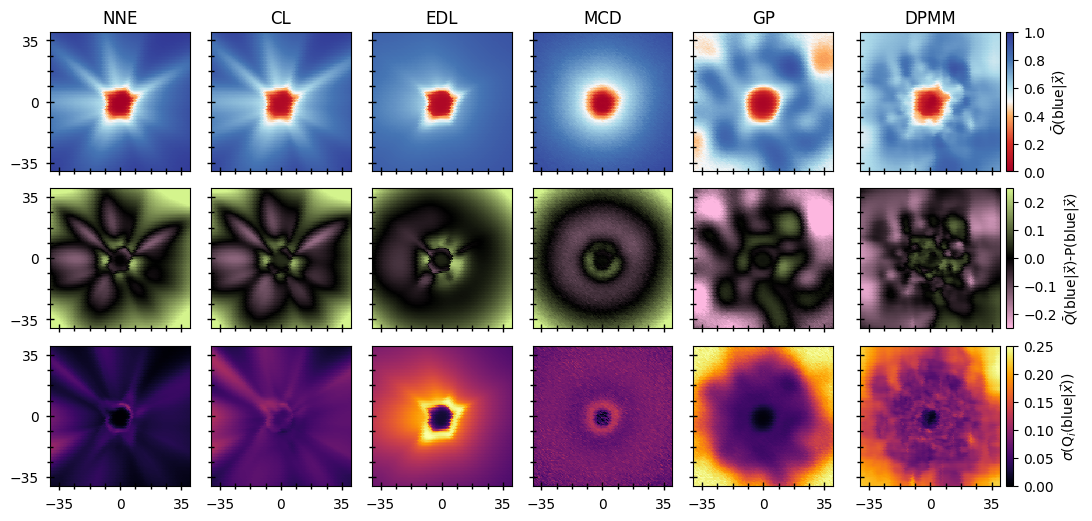

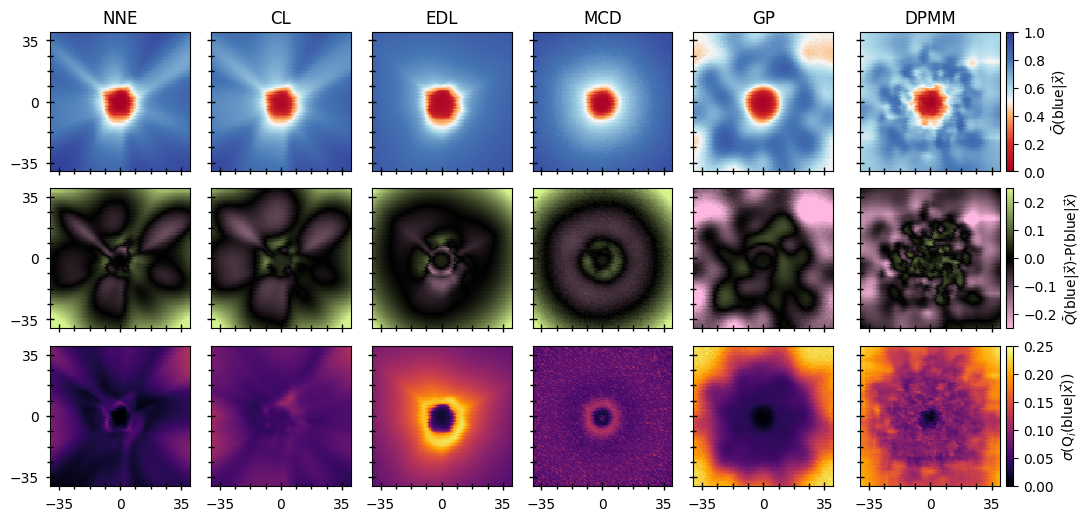

In [25]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 3, ncols = n_models, figsize = (1.8*n_models,1.7*3), layout="constrained", sharey=True, sharex=True)
    for j in range(n_models):
        axs[0][j] = plot_results(grid_dfs[j][i], prob_keys[j], axs[0][j], "", grid=True, rmax=grid_rmax)
        axs[1][j] = plot_diff(grid_dfs[j][i], grid_data, prob_keys[j], "p_c1_given_r",  axs[1][j], r"", max_val=max_err_val[i], rmax=grid_rmax)
        axs[2][j] = plot_std(grid_dfs[j][i], std_keys[j], axs[2][j], r"", grid=True, max_val=max_err_val[i], rmax=grid_rmax)
        axs[0][j].set_title(model_names[j])

    for ax in axs.flatten():
        ax.tick_params(labelsize=10, bottom=True, left=True, top=False, right=False)

    hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0][-1])
    
    hue_norm_err = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_err, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2][-1])
    
    hue_norm_std = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_std, cmap=pink_black_green_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1][-1])
    fig.savefig(f"fig/results_datasetA_grid_{n_train[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)
    

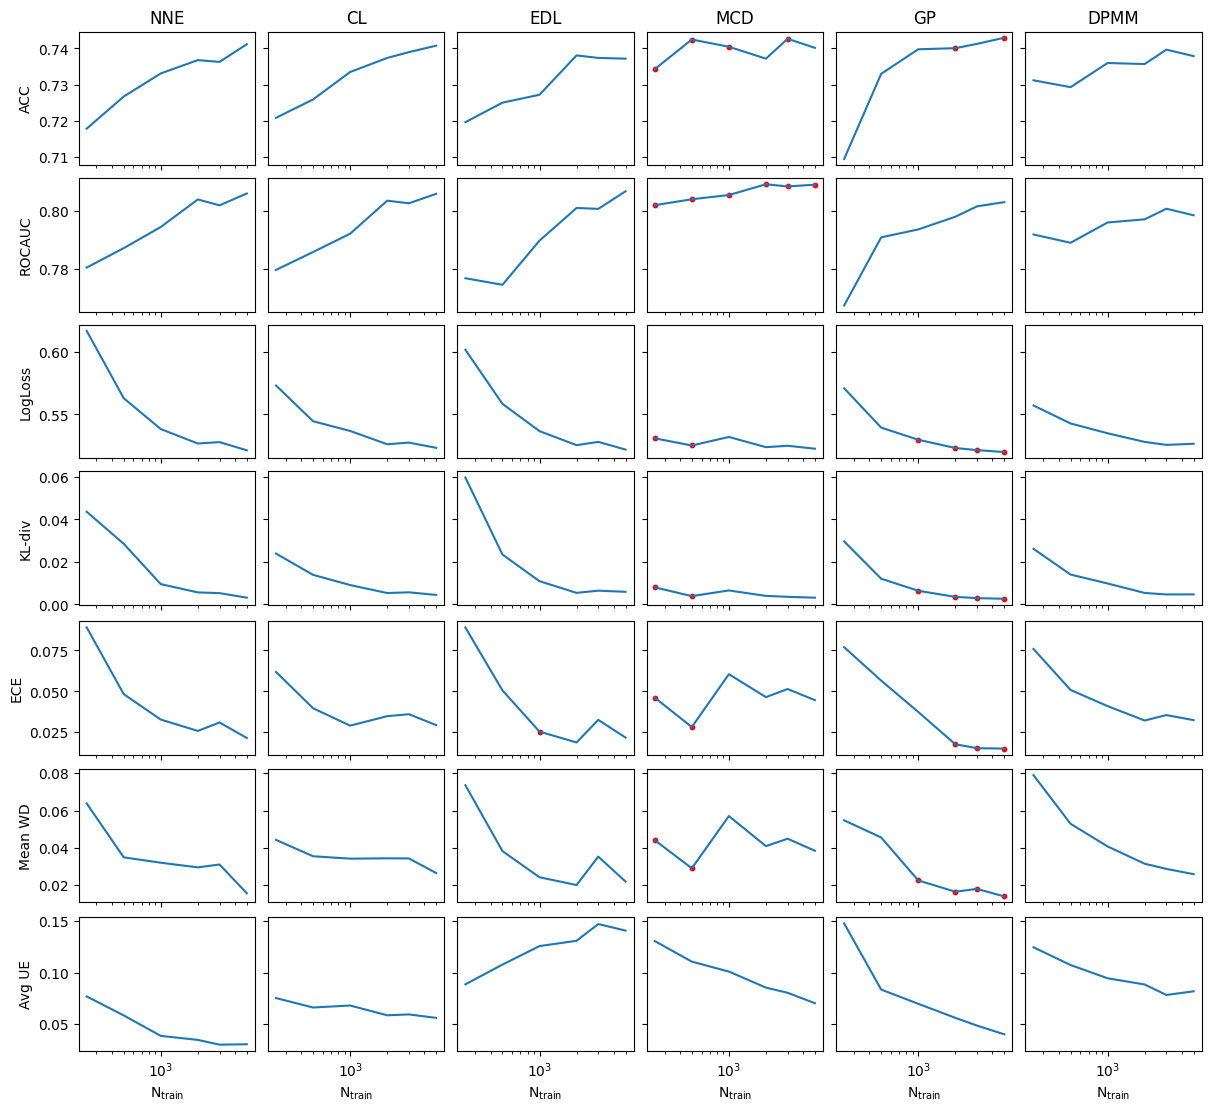

In [26]:
metric_keys = ["ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test", "Avg UE"]
fig, axs = plt.subplots(nrows = 7, ncols = n_models, figsize = (2*n_models,11), layout="constrained", sharex=True, sharey="row")
for i in range(n_models):
    axs[0][i].set_title(model_names[i])
    
    axs[0][i].plot(scores[i]["N data"], scores[i]["ACC"])
    #axs[0][i].set_ylim(0.6, 0.8)
    axs[0][0].set_ylabel("ACC")

    axs[1][i].plot(scores[i]["N data"], scores[i]["ROCAUC"])
    #axs[1][i].set_ylim(0.7, 1)
    axs[1][0].set_ylabel("ROCAUC")

    axs[2][i].plot(scores[i]["N data"], scores[i]["LogLoss"])
    #axs[2][i].set_ylim(0.4, 0.7)
    axs[2][0].set_ylabel("LogLoss")

    axs[3][i].plot(scores[i]["N data"], scores[i]["Mean KL-div test"])
    #axs[5][i].set_ylim(0, 0.08)
    axs[3][0].set_ylabel("KL-div")

    axs[4][i].plot(scores[i]["N data"], scores[i]["ECE"])
    #axs[3][i].set_ylim(0, 0.1)
    axs[4][0].set_ylabel("ECE")

    axs[5][i].plot(scores[i]["N data"], scores[i]["WD test"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[5][0].set_ylabel("Mean WD")

    axs[6][i].plot(scores[i]["N data"], scores[i]["Avg UE"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[6][0].set_ylabel("Avg UE")

    for col in axs[-1]:
        col.set_xlabel(r"N$_{\text{train}}$")

    for ax in axs.flatten():
        ax.set_xscale("log")


for j in range(len(metric_keys)-1):
    for n in range(n_plots):
        key = metric_keys[j]
        best_model = best_score[metric_keys[j]][n]
        axs[j, best_model].scatter(x=[n_train[n]], y=[scores[best_model][key][n]], marker='o', s=10, c="red")

fig.savefig(f"fig/results_datasetA_metrics.pdf", format="pdf", bbox_inches='tight', dpi=350)

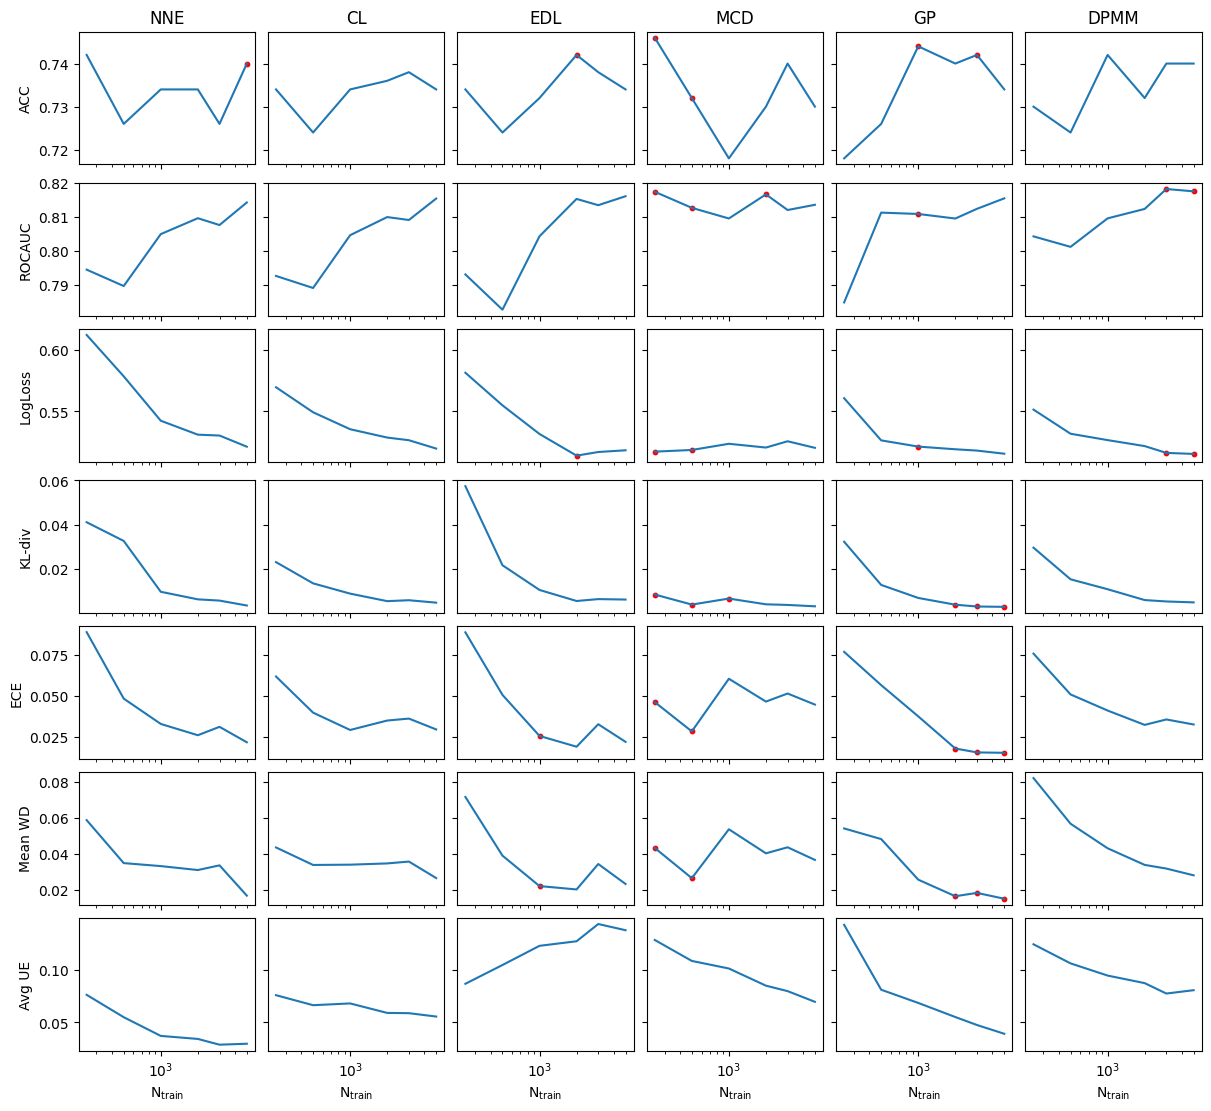

In [27]:
fig, axs = plt.subplots(nrows = 7, ncols = n_models, figsize = (2*n_models,11), layout="constrained", sharex=True, sharey="row")
for i in range(n_models):
    axs[0][i].set_title(model_names[i])
    
    axs[0][i].plot(scores_small[i]["N data"], scores_small[i]["ACC"])
    #axs[0][i].set_ylim(0.6, 0.8)
    axs[0][0].set_ylabel("ACC")

    axs[1][i].plot(scores_small[i]["N data"], scores_small[i]["ROCAUC"])
    #axs[1][i].set_ylim(0.7, 1)
    axs[1][0].set_ylabel("ROCAUC")

    axs[2][i].plot(scores_small[i]["N data"], scores_small[i]["LogLoss"])
    #axs[2][i].set_ylim(0.4, 0.7)
    axs[2][0].set_ylabel("LogLoss")

    axs[3][i].plot(scores_small[i]["N data"], scores_small[i]["Mean KL-div test"])
    #axs[5][i].set_ylim(0, 0.08)
    axs[3][0].set_ylabel("KL-div")

    axs[4][i].plot(scores_small[i]["N data"], scores_small[i]["ECE"])
    #axs[3][i].set_ylim(0, 0.1)
    axs[4][0].set_ylabel("ECE")

    axs[5][i].plot(scores_small[i]["N data"], scores_small[i]["WD test"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[5][0].set_ylabel("Mean WD")

    axs[6][i].plot(scores_small[i]["N data"], scores_small[i]["Avg UE"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[6][0].set_ylabel("Avg UE")

    for col in axs[-1]:
        col.set_xlabel(r"N$_{\text{train}}$")

    for ax in axs.flatten():
        ax.set_xscale("log")


for j in range(len(metric_keys)-1):
    for n in range(n_plots):
        key = metric_keys[j]
        best_model = best_score_small[metric_keys[j]][n]
        axs[j, best_model].scatter(x=[n_train[n]], y=[scores_small[best_model][key][n]], marker='o', s=10, c="red")


#fig.savefig(f"fig/results_metrics.pdf", format="pdf", bbox_inches='tight', dpi=350)